In [1]:
! pip install qutip qutip_qip matplotlib

# Fidelity Exercises
## exercise 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
from qutip import basis, fidelity,sigmax, sigmay, sigmaz,identity,rand_unitary,tensor,mesolve,Qobj, Bloch
from qutip.qip.operations import  rx,ry,rz,cz_gate
from typing import List

def get_fid_arr(outputs: List[qutip.Qobj],
              ideals:List[qutip.Qobj],len:int):
    return np.array([
        qutip.fidelity(outputs[i],ideals[i]) for i in range(len)
    ])
def Fid_arith(outputs: List[qutip.Qobj],
              ideals:List[qutip.Qobj],n_qbt:int):
    assert len(outputs) == len(ideals)
    d = 2**n_qbt
    assert len(outputs) == d + 1
    return np.sum(get_fid_arr(outputs,ideals,d+1)) / (d+1)

def Fid_geom(outputs: List[qutip.Qobj],
              ideals:List[qutip.Qobj],n_qbt:int):
    assert len(outputs) == len(ideals)
    d = 2**n_qbt
    assert len(outputs) == d + 1
    return 1/ (d+1) + (1-1/ (d+1)) * np.prod(get_fid_arr(outputs,ideals,d+1))

def Fid_lambda(outputs: List[qutip.Qobj],
              ideals:List[qutip.Qobj],n_qbt:int)->float:
    # Assuming the superposition of all basis states is the last state in the two lists.
    assert len(outputs) == len(ideals)
    d = 2**n_qbt
    assert len(outputs) == d + 1
    fid_arr = get_fid_arr(outputs,ideals,d+1)
    lambda_ = 1 - (1-np.prod(fid_arr[:-1]))/(1-np.prod(fid_arr))
    return lambda_* (1/ (d+1) + (1-1/ (d+1)) * np.prod(fid_arr))    + (1-lambda_)*np.sum(fid_arr) / (d+1)

In [3]:
inits = [basis(2, 0), 
                basis(2, 1),
                (basis(2, 0)+ basis(2, 1)).unit()]
outputs = [sigmax()*state for state in inits]
ideals = [sigmax() * state for state in inits]

print(f"'gate fidelity between the target X gate and itself': {Fid_lambda(ideals,ideals,1)}")
print(f"'gate fidelity between the target X gate and Y gate': {Fid_lambda(ideals,[sigmay() * state for state in inits],1)}")
print(f"'gate fidelity between the target X gate and Z gate': {Fid_lambda(ideals,[sigmaz() * state for state in inits],1)}")
print(f"'gate fidelity between the target X gate and I gate': {Fid_lambda(ideals,[identity(2) * state for state in inits],1)}")

'gate fidelity between the target X gate and itself': 1.0
'gate fidelity between the target X gate and Y gate': 0.3333333333333333
'gate fidelity between the target X gate and Z gate': 0.0
'gate fidelity between the target X gate and I gate': 0.33333333333333326


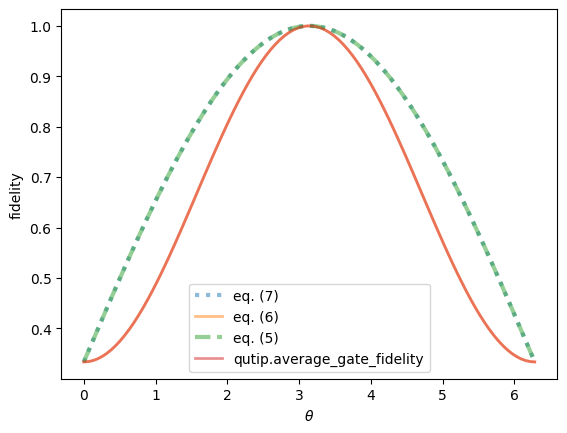

In [4]:
theta_arr = np.linspace(0,2*np.pi,100)
plt.plot(theta_arr,[
    Fid_lambda(ideals,[rx(theta) * state for state in inits],1) 
    for theta in theta_arr], label="eq. (7)",alpha=0.5,lw=3,linestyle=':')
plt.plot(theta_arr,[
    Fid_geom(ideals,[rx(theta) * state for state in inits],1) 
    for theta in theta_arr], label="eq. (6)",alpha=0.5,lw=2)
plt.plot(theta_arr,[
    Fid_arith(ideals,[rx(theta) * state for state in inits],1) 
    for theta in theta_arr], label="eq. (5)",alpha=0.5,lw=3,linestyle='--')
plt.plot(theta_arr,[
    qutip.average_gate_fidelity(rx(theta), sigmax())
    for theta in theta_arr], label="qutip.average_gate_fidelity",alpha=0.5,lw=2)
plt.xlabel(rf"$\theta$")
plt.ylabel(rf"fidelity")
plt.legend()
plt.show()

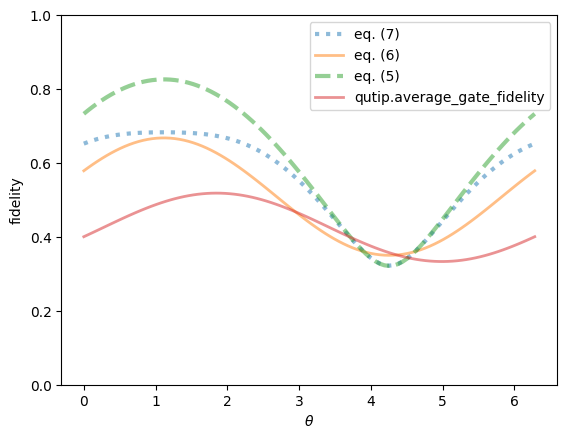

In [5]:
random_u = rand_unitary(2)
ideals = [random_u * state for state in inits]

theta_arr = np.linspace(0,2*np.pi,100)
plt.plot(theta_arr,[
    Fid_lambda(ideals,[rx(theta) * state for state in inits],1) 
    for theta in theta_arr], label="eq. (7)",alpha=0.5,lw=3,linestyle=':')
plt.plot(theta_arr,[
    Fid_geom(ideals,[rx(theta) * state for state in inits],1) 
    for theta in theta_arr], label="eq. (6)",alpha=0.5,lw=2)
plt.plot(theta_arr,[
    Fid_arith(ideals,[rx(theta) * state for state in inits],1) 
    for theta in theta_arr], label="eq. (5)",alpha=0.5,lw=3,linestyle='--')
plt.plot(theta_arr,[
    qutip.average_gate_fidelity(rx(theta), random_u)
    for theta in theta_arr], label="qutip.average_gate_fidelity",alpha=0.5,lw=2)
plt.xlabel(rf"$\theta$")
plt.ylabel(rf"fidelity")
plt.legend()
plt.ylim(0,1)
plt.show()

## Exercise 2 optimizing gate fidelity

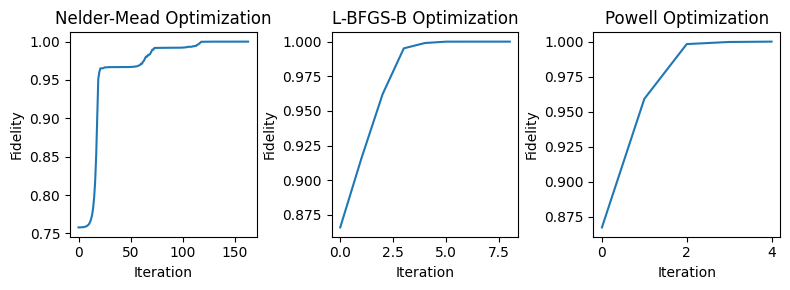

In [6]:
from scipy.optimize import minimize
def get_fide(r, U):
    r1, r2, r3 = r

    inits = [basis(2, 0), 
            basis(2, 1),
            (basis(2, 0)+ basis(2, 1)).unit()]
    outputs = [rz(r3)*rx(r2)*rz(r1)*state for state in inits]
    ideals = [U*state for state in inits]
    return -Fid_arith(ideals,outputs,1) 

U = rand_unitary(2)

optimizers = ['Nelder-Mead', 'L-BFGS-B', 'Powell']
fig, axs = plt.subplots(1,len(optimizers), figsize=(8, 3))
for i, opt in enumerate(optimizers):
    results = []
    def store_result(intermediate_result):
        results.append(-intermediate_result.fun)     
    minimize(get_fide, [0, 0, 0], args=(U,), method=opt,
             callback=store_result)

    axs[i].plot(results, label=f'{opt} Fidelity')
    axs[i].set_title(f'{opt} Optimization')
    axs[i].set_xlabel('Iteration')
    axs[i].set_ylabel('Fidelity')
    # axs[i].set_ylim(0,1)
    # axs[i].legend()

plt.tight_layout()
plt.show()

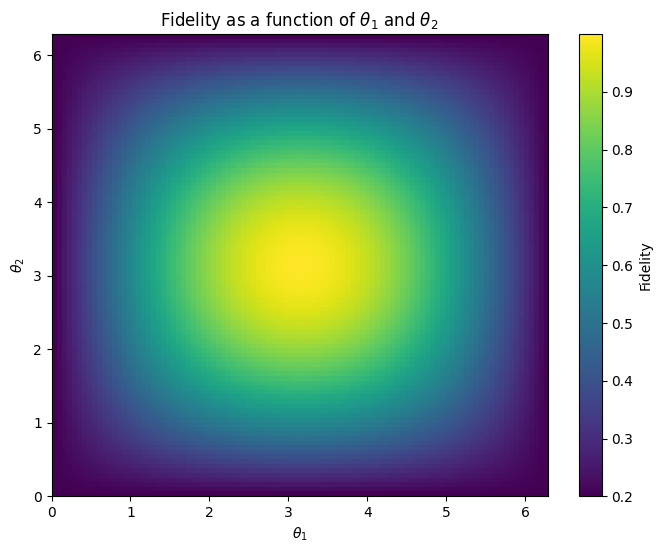

In [7]:
from scipy.optimize import minimize


def get_fide(r, U):
    r1, r2 = r

    inits = [tensor(basis(2, 0),basis(2, 0)), 
            tensor(basis(2, 0),basis(2, 1)), 
            tensor(basis(2, 1),basis(2, 0)), 
            tensor(basis(2, 1),basis(2, 1)), 

            (tensor(basis(2, 0),basis(2, 0))+
            tensor(basis(2, 0),basis(2, 1))+
            tensor(basis(2, 1),basis(2, 0))+ 
            tensor(basis(2, 1),basis(2, 1))).unit()]
    
    outputs = [tensor(rx(r1), rx(r2))*state for state in inits]
    ideals = [U*state for state in inits]
    return -Fid_arith(ideals,outputs,2) 

U = qutip.tensor(sigmax(),sigmax())

# Define ranges for θ1 and θ2
theta1_vals = np.linspace(0, 2 * np.pi, 100)
theta2_vals = np.linspace(0, 2 * np.pi, 100)

# Initialize an empty grid for storing fidelity values
fidelity_grid = np.zeros((len(theta1_vals), len(theta2_vals)))

# Calculate fidelity for each combination of θ1 and θ2
for i, theta1 in enumerate(theta1_vals):
    for j, theta2 in enumerate(theta2_vals):
        fidelity_grid[i, j] = -get_fide([theta1, theta2], U)  # Negative due to negated return in get_fide

# Plot the 2D fidelity map
plt.figure(figsize=(8, 6))
plt.imshow(fidelity_grid, extent=(0, 2 * np.pi, 0, 2 * np.pi), origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Fidelity')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Fidelity as a function of $\\theta_1$ and $\\theta_2$')
plt.show()

## Exercise 3

In [8]:
def get_fide(params, U):
    r1, r2, r3, r4, r5, r6 = params
    
    # Define the input states
    inits = [
        tensor(basis(2, 0), basis(2, 0)), 
        tensor(basis(2, 0), basis(2, 1)), 
        tensor(basis(2, 1), basis(2, 0)), 
        tensor(basis(2, 1), basis(2, 1)), 
        (tensor(basis(2, 0), basis(2, 0)) + tensor(basis(2, 0), basis(2, 1)) +
         tensor(basis(2, 1), basis(2, 0)) + tensor(basis(2, 1), basis(2, 1))).unit()
    ]
    
    # Construct the approximate unitary using the six parameters
    approx_gate = tensor(rz(r3) * rx(r2) * rz(r1), rz(r6) * rx(r5) * rz(r4))
    outputs = [approx_gate * state for state in inits]
    ideals = [U * state for state in inits]
    
    # Return the negative fidelity (for maximization via minimization)
    return -Fid_lambda(outputs, ideals, 2)

# Define a random target 2-qubit unitary
U = qutip.Qobj(rand_unitary(4, 4).full(), dims=[[2, 2], [2, 2]])

# Initial guess for the six parameters
initial_guess = [0, 0, 0, 0, 0, 0]

# Perform optimization to maximize fidelity
result = minimize(get_fide, initial_guess, args=(U,), method='Nelder-Mead')
optimized_params = result.x

# Display optimized parameters and maximum fidelity achieved
print(f"Optimized parameters: r1 = {optimized_params[0]}, r2 = {optimized_params[1]}, r3 = {optimized_params[2]}, "
      f"r4 = {optimized_params[3]}, r5 = {optimized_params[4]}, r6 = {optimized_params[5]}")
print(f"Maximized fidelity: {-result.fun}")

Optimized parameters: r1 = 0.6147718273804575, r2 = 0.8705688631852528, r3 = 1.9419574126032026, r4 = 0.5041262976566586, r5 = -2.2915820959327933, r6 = 0.968288456325652
Maximized fidelity: 0.7829621748868355


can't achieve entangling by single qubit gates

## Exercise 1 X gate

In [9]:
ground = basis(4, 0)
excited = basis(4, 1)
leakage = basis(4, 2)
rydberg = basis(4, 3)

gamma_r = 1 / (540)
L0 = np.sqrt(1/16 * gamma_r) * (ground * rydberg.dag())
L1 = np.sqrt(1/16 * gamma_r) * (excited * rydberg.dag())
Ld = np.sqrt(7/8 * gamma_r) * (leakage * rydberg.dag())
collapse_ops = [L0, L1, Ld]

def Rabi_frequency(t,args):
    t0=args['t0']
    sigma=args['sigma']
    amp=args['amp']
    return amp*np.exp(-(t-t0)**2/(2*sigma**2))


H = [
    [0.5*ground*excited.dag()+0.5*excited*ground.dag(),
    Rabi_frequency],
]

# Initial state |0>
initial_state = ground


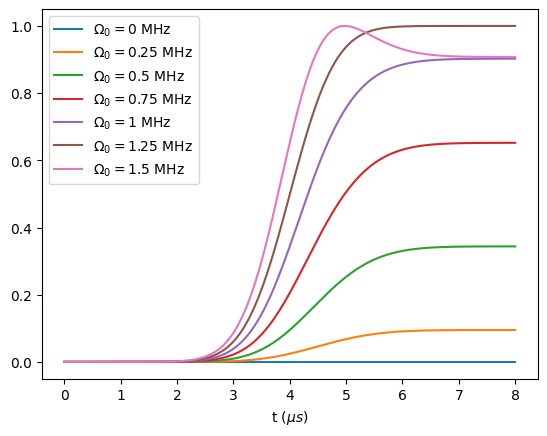

In [10]:
# Time evolution
times = np.linspace(0, 8, 1000)
for amp_in_MHz in [0,0.25,0.5,0.75,1,1.25,1.5]:
    amp_in_GHz = amp_in_MHz
    result = mesolve(H=H, rho0=initial_state, tlist=times, c_ops=collapse_ops, e_ops = [excited * excited.dag()],
                    args={'sigma':1,'amp':amp_in_MHz,'t0':4})
    plt.plot(times,result.expect[0],label=f'$\Omega_0=${amp_in_MHz} MHz')
plt.xlabel( r't ($\mu s$)')
plt.legend()
plt.show()

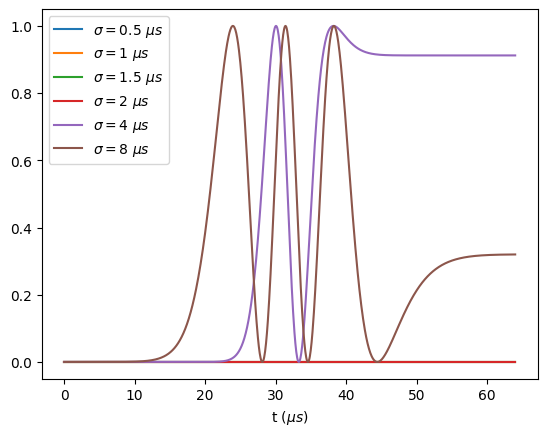

In [11]:
# Time evolution
times = np.linspace(0, 64, 1000)
for sigma in [0.5,1,1.5,2,4,8]:
    result = mesolve(H=H, rho0=initial_state, tlist=times, c_ops=collapse_ops, e_ops = [excited * excited.dag()],
                    args={'sigma':sigma,'amp':1,'t0':32})
    plt.plot(times,result.expect[0],label=f'$\sigma=${sigma} $\mu s$')
plt.xlabel( r't ($\mu s$)')
plt.legend()

sigma:1.2533141373155003 mu s


/var/folders/9k/z8bpg3hj3d9841ggs75xmwxw0000gn/T/ipykernel_78447/3806807446.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/Users/jiakaiwang/miniconda3/envs/newest_qutip/lib/python3.10/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


np.float64(0.9982981117405633)

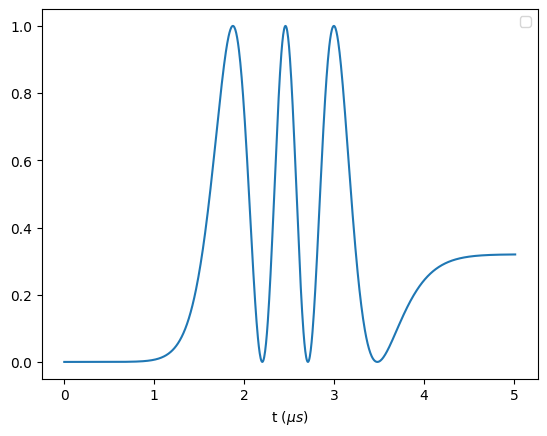

In [12]:
sigma = np.pi/np.sqrt(2*np.pi)
print(f"sigma:{sigma} mu s")
num_sigma = 4
times = np.linspace(0, num_sigma*sigma, 1000)
plt.plot(times,result.expect[0])
plt.xlabel( r't ($\mu s$)')
plt.legend()

inits = [basis(4, 0), 
        basis(4, 1),
        (basis(4, 0)+ basis(4, 1)).unit()]



outputs = [qutip.Qobj(mesolve(H=H, rho0=state, tlist=times, c_ops=collapse_ops, e_ops = [excited * excited.dag()],
                args={'sigma':sigma,'amp':1,'t0':num_sigma*sigma/2},
                options=qutip.solver.Options(store_final_state=True)).final_state.full()[:2,:2]) for state in inits]
ideals = [sigmax()*qutip.Qobj(state.full()[:2]) for state in inits]
Fid_arith(ideals,outputs,1) 

## I expect truncation of total gate length to be a major source of error

In [13]:
num_sigma = 6
amp = 1

# Function to compute fidelity given a specific sigma
def compute_fidelity(x):
    sigma=x[0]
    # Generate the time list based on current sigma
    times = np.linspace(0, num_sigma * sigma, 1000)
    
    # Define initial states
    inits = [
        basis(4, 0), 
        basis(4, 1),
        (basis(4, 0) + basis(4, 1)).unit()
    ]
    
    # Run simulation for each initial state
    outputs = [
        Qobj(
            mesolve(
                H=H, 
                rho0=state, 
                tlist=times, 
                c_ops=collapse_ops, 
                e_ops=[excited * excited.dag()],
                args={'sigma': sigma, 'amp': amp, 't0': num_sigma * sigma / 2},
                options=qutip.solver.Options(store_final_state=True)
            ).final_state.full()[:2, :2]
        ) 
        for state in inits
    ]
    
    # Define ideal outputs using a target operation
    ideals = [sigmax() * Qobj(state.full()[:2]) for state in inits]
    
    # Calculate the arithmetic fidelity
    return -Fid_arith(ideals, outputs, 1)  # Negative for minimization

# Initial guess for sigma (you can start with your current sigma)
initial_sigma = np.pi / np.sqrt(2 * np.pi)

# Perform optimization to maximize fidelity
result = minimize(compute_fidelity, [initial_sigma], method='L-BFGS-B')
optimal_sigma = result.x[0]

# Output optimized sigma and plot the final result
print(f"Optimized sigma: {optimal_sigma} μs, result:{result.fun}")

Optimized sigma: 1.256705802304981 μs, result:-1.0000000762406012


## very close

In [14]:
sigma = optimal_sigma
times = np.linspace(0, num_sigma * sigma, 40)
amp = 1

initial_states = [basis(4, 0), basis(4, 1)]

def truncate_to_two_level(state):
    return Qobj(state.full()[:2, :2])

bloch_x1, bloch_y1, bloch_z1 = [], [], []
bloch_x2, bloch_y2, bloch_z2 = [], [], []
sigmax_4 = Qobj(np.array([[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]))
sigmay_4 = Qobj(np.array([[0, -1j, 0, 0], [1j, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]))
sigmaz_4 = Qobj(np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]))

for state in initial_states:
    result = mesolve(
        H=H, 
        rho0=state, 
        tlist=times, 
        c_ops=collapse_ops, 
        e_ops=[sigmax_4, sigmay_4, sigmaz_4],
        args={'sigma': sigma, 'amp': amp, 't0': num_sigma * sigma / 2}
    )
    
    if state == basis(4, 0):
        bloch_x1, bloch_y1, bloch_z1 = result.expect[0], result.expect[1], result.expect[2]
    else:
        bloch_x2, bloch_y2, bloch_z2 = result.expect[0], result.expect[1], result.expect[2]


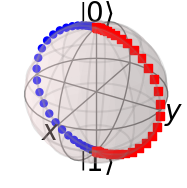

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.subplot(211, projection='3d')
b = qutip.Bloch(fig=fig, axes=ax)
b.add_points([bloch_x1, bloch_y1, bloch_z1])  # Trajectory for basis(4, 0)
b.add_points([bloch_x2, bloch_y2, bloch_z2])  # Trajectory for basis(4, 1)
b.make_sphere()
b.render()
plt.show()

## Exercise 2 Z gate

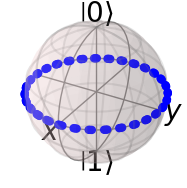

In [16]:
delta_1 = 1 #MHz
H = delta_1 * (excited * excited.dag())
times = np.linspace(0, 20, 100)
initial_state = (basis(4, 0) + basis(4, 1)).unit()
result = mesolve(H=H,
                    rho0=initial_state, 
                    tlist=times, 
                    c_ops=collapse_ops,
                    e_ops=[sigmax_4, sigmay_4, sigmaz_4],)
bloch_x1, bloch_y1, bloch_z1 = result.expect[0], result.expect[1], result.expect[2]
fig = plt.figure()
ax = plt.subplot(211, projection='3d')
b = qutip.Bloch(fig=fig, axes=ax)
b.add_points([bloch_x1, bloch_y1, bloch_z1])
b.make_sphere()
b.render()
plt.show()

In [17]:
def compute_fidelity(x):
    times = np.linspace(0, x[0], 1000)
    
    inits = [
        basis(4, 0), 
        basis(4, 1),
        (basis(4, 0) + basis(4, 1)).unit()
    ]
    
    outputs = [
        Qobj(
            mesolve(
                H=H, 
                rho0=state, 
                tlist=times, 
                c_ops=collapse_ops, 
                options={'store_final_state':True}
            ).final_state.full()[:2, :2]
        ) 
        for state in inits
    ]
    
    ideals = [sigmaz() * Qobj(state.full()[:2]) for state in inits]
    
    return -Fid_arith(ideals, outputs, 1)  # Negative for minimization

initial_T=20

result = minimize(compute_fidelity, [initial_T], method='L-BFGS-B')
optimal_T = result.x[0]
print(f"Optimized T: {optimal_T} μs, result:{result.fun}")

Optimized T: 21.991155283353105 μs, result:-0.9999849284099556


In [18]:
21.991155283353105 * delta_1

21.991155283353105

I expect the fidelity to be one, because there's no decay in the 0-1 manifold

## Exercise 3 CZ

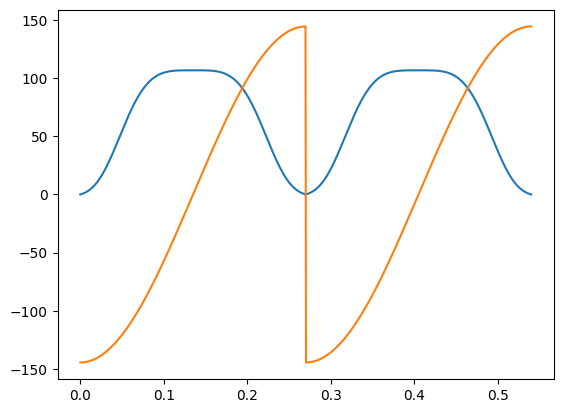

In [19]:
t_tot = 0.540 #microsecond, which is the total duration of the gate protocol
B=100*2*np.pi #interaction strength
omegaMax = 17*2*np.pi #Mhz
deltaMax = 23*2*np.pi #Mhz
tau = 0.175*t_tot 
a = np.exp(-(t_tot/4)**4/tau**4)
times = np.linspace(0,t_tot,1000)
def Rabi_frequency(t,):
    return (t<t_tot/2)*omegaMax*(np.exp(-(t-t_tot/4)**4/tau**4)-a)/(1-a)    \
      +    (t>=t_tot/2)*omegaMax*(np.exp(-(t-3*t_tot/4)**4/tau**4)-a)/(1-a)
def Detunning(t):
    return (t<t_tot/2)*(-1)*deltaMax*np.cos(2*np.pi*t/t_tot) \
              +    (t>=t_tot/2)*deltaMax*np.cos(2*np.pi*t/t_tot)
plt.plot(times,Rabi_frequency(times))
plt.plot(times,Detunning(times))

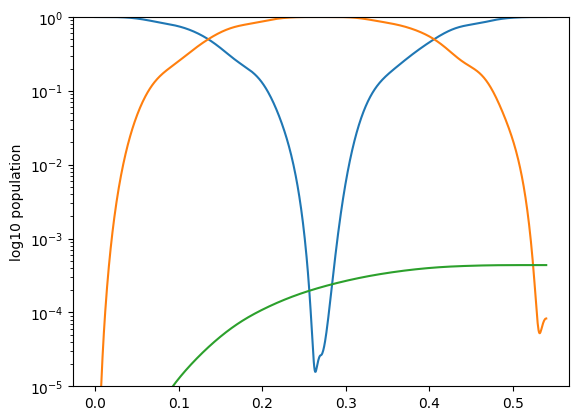

In [20]:

H = [
    [tensor(0.5*rydberg*excited.dag()+0.5*excited*rydberg.dag(),                identity(4)) 
    +tensor(identity(4),                0.5*rydberg*excited.dag()+0.5*excited*rydberg.dag()),
    Rabi_frequency],
    [tensor(rydberg*rydberg.dag(),          identity(4))
    +tensor(identity(4),            rydberg*rydberg.dag()),
     Detunning],
    B*tensor(rydberg,rydberg)*tensor(rydberg,rydberg).dag()
]

projections = [tensor(excited*excited.dag(),ground*ground.dag()),
                        tensor(rydberg*rydberg.dag(),ground*ground.dag()),
                        tensor(leakage*leakage.dag(),identity(4)),
                        tensor(identity(4),leakage*leakage.dag())
                        ]
gamma_r = 1 / 540
L0 = np.sqrt(1/16 * gamma_r) * (ground * rydberg.dag())
L1 = np.sqrt(1/16 * gamma_r) * (excited * rydberg.dag())
Ld = np.sqrt(7/8 * gamma_r) * (leakage * rydberg.dag())

collapse_ops = [tensor(L0,identity(4)), 
                tensor(L1,identity(4)), 
                tensor(Ld,identity(4)), 
                tensor(identity(4),L0), 
                tensor(identity(4),L1), 
                tensor(identity(4),Ld)]

result = mesolve(H = H, 
                rho0 = tensor(excited,ground), 
                tlist = times, 
                c_ops = collapse_ops,
                e_ops = projections)


fig, ax = plt.subplots()
for i in range(len(projections)):
    ax.plot(times, result.expect[i])
plt.yscale('log')
plt.ylim(0.00001,1.01)
plt.ylabel("log10 population")
plt.show()

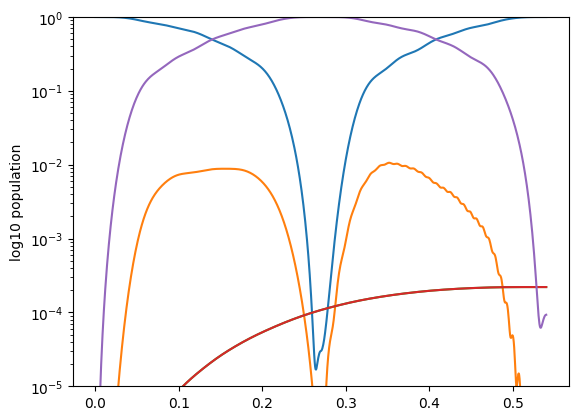

In [21]:
psi0 = tensor(excited,excited)
projections = [tensor(excited*excited.dag(),excited*excited.dag()),
                        tensor(rydberg*rydberg.dag(),rydberg*rydberg.dag()),
                        tensor(identity(4),leakage*leakage.dag()),
                        tensor(leakage*leakage.dag(),identity(4)),
                        tensor(rydberg*rydberg.dag(),excited*excited.dag()),
                        tensor(excited*excited.dag(),rydberg*rydberg.dag()),
                        ]
result = mesolve(H = H, 
                rho0 = psi0, 
                tlist = times, 
                c_ops = collapse_ops,
                e_ops = projections)


fig, ax = plt.subplots()

ax.plot(times, result.expect[0])
ax.plot(times, result.expect[1],)
ax.plot(times, result.expect[2])
ax.plot(times, result.expect[3])

ax.plot(times, result.expect[4]+result.expect[5])
plt.yscale('log')
plt.ylim(0.00001,1.01)
plt.ylabel("log10 population")
plt.show()

In [22]:
from qutip import basis, Qobj

def get_2lvl(rho):
    if rho.isket:
        rho = qutip.ket2dm(rho)
    rho_arr = rho.full()
    rho_2lvl=rho_arr.reshape(4,4,4,4)[:2,:2,:2,:2]
    return Qobj(rho_2lvl.reshape(4,4),dims=[[2,2],[2,2]])

inits = [
    tensor(basis(4, 0),basis(4,0)),
    tensor(basis(4, 0),basis(4,1)),
    tensor(basis(4, 1),basis(4,0)),
    tensor(basis(4, 1),basis(4,1)),

    (tensor(basis(4, 0),basis(4,0)) \
     +tensor(basis(4, 0),basis(4,1))\
     +tensor(basis(4, 1),basis(4,0)) \
     +tensor(basis(4, 1),basis(4,1))).unit()
]

outputs = [
    get_2lvl(Qobj(
        mesolve(
            H=H, 
            rho0=state, 
            tlist=times, 
            c_ops=collapse_ops, 
            options={'store_final_state':True}
        ).final_state.full()
    ))
    for state in inits
]

CZ = Qobj(np.diag([1,-1,-1,-1]),dims=[[2,2],[2,2]]) 
ideals = [CZ* get_2lvl(state) *CZ for state in inits]

Fid_arith(ideals, outputs, 2) 

np.float64(0.969367563694953)

In [23]:
for gamma_r in [1/5,1/50, 1/100, 1/250, 1/540,1/1e3]:
    L0 = np.sqrt(1/16 * gamma_r) * (ground * rydberg.dag())
    L1 = np.sqrt(1/16 * gamma_r) * (excited * rydberg.dag())
    Ld = np.sqrt(7/8 * gamma_r) * (leakage * rydberg.dag())
    collapse_ops = [tensor(L0,identity(4)), 
                    tensor(L1,identity(4)), 
                    tensor(Ld,identity(4)), 
                    tensor(identity(4),L0), 
                    tensor(identity(4),L1), 
                    tensor(identity(4),Ld)]

    outputs = [
        get_2lvl(Qobj(
            mesolve(
                H=H, 
                rho0=state, 
                tlist=times, 
                c_ops=collapse_ops, 
                options={'store_final_state':True}
            ).final_state.full()
        ))
        for state in inits
    ]
    print(f"fid with gamma_r = {gamma_r} = {Fid_arith(ideals, outputs, 2)}")

    print(f"average leakage = {np.mean([1-state.tr() for state in outputs])}")

fid with gamma_r = 0.2 = 0.9505811413128337
average leakage = 0.03718281336481717
fid with gamma_r = 0.02 = 0.967624433162627
average leakage = 0.0038518784383652304
fid with gamma_r = 0.01 = 0.9685792160146599
average leakage = 0.0019526992944109089
fid with gamma_r = 0.004 = 0.969163516572117
average leakage = 0.0008088947390423762
fid with gamma_r = 0.001851851851851852 = 0.969367563694953
average leakage = 0.00039959398649376255
fid with gamma_r = 0.001 = 0.9694506812199398
average leakage = 0.0002372269428048579


In [25]:
last_x = [0.54,
            17*2*np.pi,
            23*2*np.pi,
            ]
for B in [50*2*np.pi,
          100*2*np.pi,
          200*2*np.pi,
          300*2*np.pi,
          400*2*np.pi,
          500*2*np.pi,
          600*2*np.pi,
          700*2*np.pi,
          800*2*np.pi,
          900*2*np.pi,
          1000*2*np.pi]:

    def compute_fidelity(x):
        t_tot = x[0]
        omegaMax = x[1]
        deltaMax = x[2]
        tau = 0.175*t_tot 
        a = np.exp(-(t_tot/4)**4/tau**4)
        times = np.linspace(0,t_tot,1000)
        def Rabi_frequency(t,):
            return (t<t_tot/2)*omegaMax*(np.exp(-(t-t_tot/4)**4/tau**4)-a)/(1-a)    \
            +    (t>=t_tot/2)*omegaMax*(np.exp(-(t-3*t_tot/4)**4/tau**4)-a)/(1-a)
        def Detunning(t):
            return (t<t_tot/2)*(-1)*deltaMax*np.cos(2*np.pi*t/t_tot) \
                    +    (t>=t_tot/2)*deltaMax*np.cos(2*np.pi*t/t_tot)

        H = [
            [tensor(0.5*rydberg*excited.dag()+0.5*excited*rydberg.dag(),                identity(4)) 
            +tensor(identity(4),                0.5*rydberg*excited.dag()+0.5*excited*rydberg.dag()),
            Rabi_frequency],
            [tensor(rydberg*rydberg.dag(),          identity(4))
            +tensor(identity(4),            rydberg*rydberg.dag()),
            Detunning],
            B*tensor(rydberg,rydberg)*tensor(rydberg,rydberg).dag()
        ]

        outputs = [
            get_2lvl(Qobj(
                mesolve(
                    H=H, 
                    rho0=state, 
                    tlist=times, 
                    c_ops=collapse_ops, 
                    options={'store_final_state':True}
                ).final_state.full()
            ))
            for state in inits
        ]
        # print(Fid_arith(ideals, outputs, 2))
        return -Fid_arith(ideals, outputs, 2)

    result = minimize(compute_fidelity, last_x, method='L-BFGS-B',options={'ftol': 1e-5})
    print(f"at B = {B}, optimized T: {result.x[0]} μs, optimized Rabi_freq: {result.x[1]} MHz, optimized detuning: {result.x[2]} MHz, result:{-result.fun}")
    last_x = result.x
    # print(f"at B = {B}, optimized T: {result.x[0]} μs,  result:{-result.fun}")

at B = 314.1592653589793, optimized T: 0.18459461447165737 μs, optimized Rabi_freq: 106.81861289037447 MHz, optimized detuning: 144.5262735074809 MHz, result:0.9456570967499653
at B = 628.3185307179587, optimized T: 0.18459460686052787 μs, optimized Rabi_freq: 106.81861288218731 MHz, optimized detuning: 144.52627350499162 MHz, result:0.9706410543189389
at B = 1256.6370614359173, optimized T: 0.18459460662274824 μs, optimized Rabi_freq: 106.81861288221971 MHz, optimized detuning: 144.52627350501336 MHz, result:0.9735064397593296
at B = 1884.9555921538758, optimized T: 0.5297041223208144 μs, optimized Rabi_freq: 106.79914167068698 MHz, optimized detuning: 144.50209206110003 MHz, result:0.9965075967630227
at B = 2513.2741228718346, optimized T: 0.4960906113467531 μs, optimized Rabi_freq: 106.79098676060147 MHz, optimized detuning: 144.50156613482173 MHz, result:0.9981594552239283
at B = 3141.592653589793, optimized T: 0.4960906113467531 μs, optimized Rabi_freq: 106.79098676060147 MHz, opt

the fidelity increases with increasing interaction strength